Import required libraries

In [108]:
! pip install --upgrade tensorflow

In [109]:
import nltk
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from matplotlib import pyplot as plt
from random import randint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

download necessary Natural language toolkit libriries for lemmen and tokenization

In [110]:
nltk.download(['punkt','punkt_tab','stopwords'], quiet=True)

True

separate data into train test sets

In [111]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/train.csv', sep=',', encoding='utf-8')
test_df = pd.read_csv('https://raw.githubusercontent.com/Jana-Liebenberg/2401PTDS_Classification_Project/main/Data/processed/test.csv', sep=',', encoding='utf-8')

View dimensions of graph

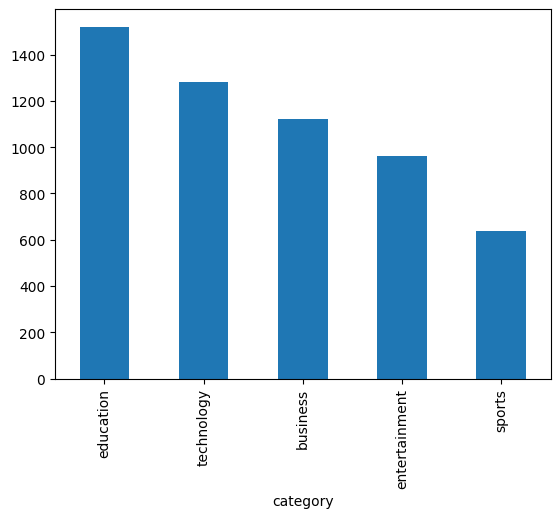

In [112]:
train_df['category'].value_counts().plot(kind='bar')
plt.show()

### 1) Format data
in the following order:
1) test on headline data given it is easier to split


In [113]:

def remove_punctuation_numbers_and_stopwords(text):
    text = text.lower()

    pun_nums = string.punctuation + "0123456789"
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)

    filterd_text = " ".join([w for w in word_tokens if w not in (stop_words and pun_nums)])

    second_check = re.sub(r'[^\w\s]','',filterd_text)

    return second_check

In [114]:
"""
Here we remove any punctuations and numbers that might have been in the data using the method declared
before for:
"""

#Headlines Data:
train_df['headlines'] = train_df['headlines'].apply(remove_punctuation_numbers_and_stopwords)
test_df['headlines'] = test_df['headlines'].apply(remove_punctuation_numbers_and_stopwords)

#Description Data:
train_df['description'] = train_df['description'].apply(remove_punctuation_numbers_and_stopwords)
test_df['description'] = test_df['description'].apply(remove_punctuation_numbers_and_stopwords)

#Content Data:
train_df['content'] = train_df['content'].apply(remove_punctuation_numbers_and_stopwords)
test_df['content'] = test_df['content'].apply(remove_punctuation_numbers_and_stopwords)

In [115]:
""""
Here we format our target variables:

"""
y_train = train_df['category']
y_test = test_df['category']

y_train.shape

(5520,)

In [116]:
"""
Here we format our featurs:

Since CountVectorizer has a paramenter for stopwords, we dont need to implement a method
to identify them.

"""
def vectorize_data(column):
    vect = CountVectorizer(min_df=0.01)
    X_train = vect.fit_transform(train_df[column]).toarray()       #we use .toarray() to convert the matrix into a numpy array
    X_test = vect.transform(test_df[column]).toarray()

    return X_train, X_test

X_headlines_train, X_headlines_test = vectorize_data('headlines')
X_deascription_train, X_deascription_test = vectorize_data('description')
X_content_train, X_content_test = vectorize_data('content')


print('X_headlines-train:',X_headlines_train.shape)
print('X_headlines-test:',X_headlines_test.shape)

X_headlines-train: (5520, 151)
X_headlines-test: (2000, 151)


In [117]:
# 6. Create a Random forest model:

def fit_random_forest(X_train, y_train, X_test):

  clf_model = RandomForestClassifier()
  clf_model.fit(X_train, y_train)

  tree = clf_model.estimators_[0]
  dot_data = export_graphviz(tree,filled=True,rounded=True,class_names=y_train.unique(),special_characters=True)
  graph = graphviz.Source(dot_data)
  accuracy = clf_model.score(X_test, y_test)

  return clf_model, graph, accuracy

clf_model, clf_accuracy, clf_graph = fit_random_forest(X_headlines_train, y_train, X_headlines_test)
print('Random Forest Accuracy:', clf_accuracy)



In [123]:
# Create a Neural Network model:
def fit_neural_network(X_train, y_train, X_test):

  lable_encoder = LabelEncoder()
  X_train = lable_encoder.fit_transform(X_)
  y_train = lable_encoder.fit_transform(y_test)
  X_len = X_train.shape[1]


  model = Sequential([
      Dense(X_len, activation='relu', input_shape=(len(y_train),)),
      Dense(X_len*2, activation='relu'),
      Dense(y_train.nunique(), activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
      )

  prediction = model.fit(X_train ,y_train)

  loss, accuracy = model.evaluate(X_headlines_test, y_test)

  return loss, accuracy

loss, accuracy = fit_neural_network(X_headlines_train, y_train, X_headlines_test)

print('Neural Network Accuracy:', accuracy)

UnboundLocalError: cannot access local variable 'y_test' where it is not associated with a value